<IPython.core.display.Javascript object>


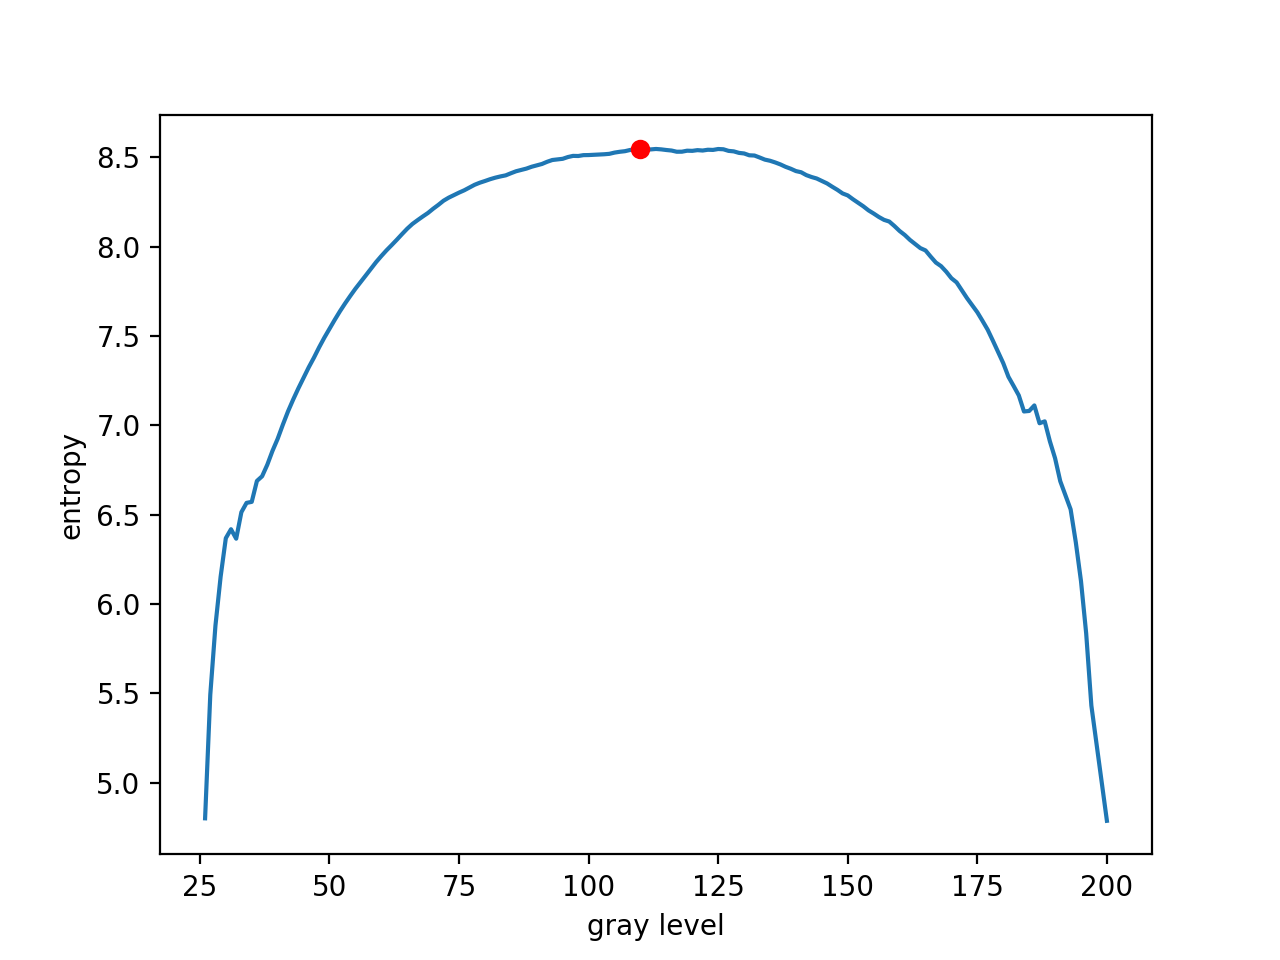

计算出阈值为110
最大熵为8.54868905424226


In [2]:
%matplotlib notebook
import numpy as np
import cv2 as cv
import matplotlib
from matplotlib import pyplot as plt


def max_entropy_1d(hist_normal):
    """
    Implements Kapur-Sahoo-Wong (Maximum Entropy) thresholding method
    Kapur J.N., Sahoo P.K., and Wong A.K.C. (1985) "A New Method for Gray-Level Picture Thresholding Using the Entropy
    of the Histogram", Graphical Models and Image Processing, 29(3): 273-285
    参考：https://github.com/zenr/ippy/blob/master/segmentation/max_entropy.py
    Params:
        hist_normal [np.array]: 归一化后的图像灰度直方图。
    Return:
        threshold [int]: threshold
    """

    # calculate normalized CDF (cumulative density function)
    cdf_normal = hist_normal.cumsum()

    valid_range = np.nonzero(hist_normal)[0]
    s_range = hist_normal[hist_normal != 0]
    H_s_cum = -np.cumsum(s_range * np.log(s_range))

    H_n = H_s_cum[-1]

    max_ent, threshold = 0, 0
    ents = []
    for i in range(len(H_s_cum) - 1): # 忽略最后一个非零点，防止P_s为1导致(1 - P_s)为0
        s = valid_range[i]
        P_s = cdf_normal[s]
        H_s = H_s_cum[i]
        total_ent = np.log(P_s * (1 - P_s)) + H_s/P_s + (H_n - H_s)/(1 - P_s)
        
        ents.append(total_ent)
        # find max
        if total_ent > max_ent:
            max_ent, threshold = total_ent, s

    return threshold, max_ent, valid_range, ents

def calc_border_mask(img, T_percent):
    """计算得到边缘附近像素点位置的掩模。
    1. 使用拉普拉斯算子计算得到img的边缘图像
    2. 选取边缘图像最大值的T_percent作为阈值对边缘图像做阈值处理，得到一幅二值图像。该二值图像即为结果（亮点即可认为是边缘附近的像素点）
    """
    lap_img = abs(cv.Laplacian(img, -1))
    # lap_kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])
    # lap_img = abs(cv.filter2D(img, -1, lap_kernel))
    lap_hist = cv.calcHist([lap_img], [0], None, [256], [0,256])

    T = np.max(lap_img) * T_percent # 阈值取拉普拉斯图像中最大值的xx%
    _, border_mask = cv.threshold(lap_img, T, 255, cv.THRESH_BINARY)
    return border_mask

img_name = 'img/lena_std.tif'
img = cv.imread(img_name, cv.IMREAD_GRAYSCALE)

border_mask = calc_border_mask(img, T_percent=0.2)
masked_img_hist = cv.calcHist([img], [0], border_mask, [256], [0,256])
masked_img_hist_normal = cv.normalize(masked_img_hist.ravel(), None, norm_type=cv.NORM_L1).ravel()

threshold, max_ent, valid_range, ents = max_entropy_1d(masked_img_hist_normal)


_, thr_img = cv.threshold(img, threshold, 255, cv.THRESH_BINARY)

plt.plot(valid_range[:-1], ents)
plt.plot(threshold, max_ent, 'ro')
plt.xlabel('gray level')
plt.ylabel('entropy')
print(f'计算出阈值为{threshold}')
print(f'最大熵为{max_ent}')